# Advanced Chunking Methods for RAG

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/pinecone-io/examples/blob/master/learn/generation/better-rag/02b-semantic-chunking.ipynb)

Semantic chunking takes the idea of chunking documents (usually for RAG) to optimize for their end state of _vector embeddings_. Vector embeddings are retrieved based on semantic similarity, and _semantic chunking_ focuses on building chunks using the exact same mechanism.

That means that we optimize our chunks for ideal retrieval performance. In essence, we are doing this by identifying the optimal chunk size that maintains a concise semantic meaning. A concise semantic meaning is important because we are compressing our chunk into a _single_ vector embedding, so if the meaning of that chunk is not concise we would, in theory, produce suboptimal embeddings that are attempting to capture multiple meanings into a single vector, which just isn't possible — at best, we produce a type of _average_ over the multiple meanings.

In this example, we'll explore semantic chunking and see the full pipeline from raw data through to chunking and embedding our data, ready for RAG.

In [96]:
!pip install -qU \
    semantic-router==0.1.8 \
    pinecone==7.0.2 \
    datasets==3.6.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
types-requests 2.32.0.20250301 requires urllib3>=2, but you have urllib3 1.26.20 which is incompatible.


In [97]:
from datasets import load_dataset

# Remove [:100] to train on the whole dataset
dataset = load_dataset("jamescalam/ai-arxiv2", split="train[:100]")


Let's initialize our encoder which will be used to identify semantically concise splits in our dataset.

In [98]:
dataset

Dataset({
    features: ['id', 'title', 'summary', 'source', 'authors', 'categories', 'comment', 'journal_ref', 'primary_category', 'published', 'updated', 'content', 'references'],
    num_rows: 100
})

In [99]:
import os
from getpass import getpass
from semantic_router.encoders import OpenAIEncoder

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass("OpenAI API key: ")

encoder = OpenAIEncoder(name="text-embedding-3-small")

In [100]:
from semantic_router.splitters import RollingWindowSplitter
from semantic_router.utils.logger import logger

logger.setLevel("WARNING")  # reduce logs from splitter

splitter = RollingWindowSplitter(
    encoder=encoder,
    dynamic_threshold=True,
    min_split_tokens=100,
    max_split_tokens=500,
    window_size=2,
    plot_splits=True,  # set this to true to visualize chunking
    enable_statistics=True  # to print chunking stats
)

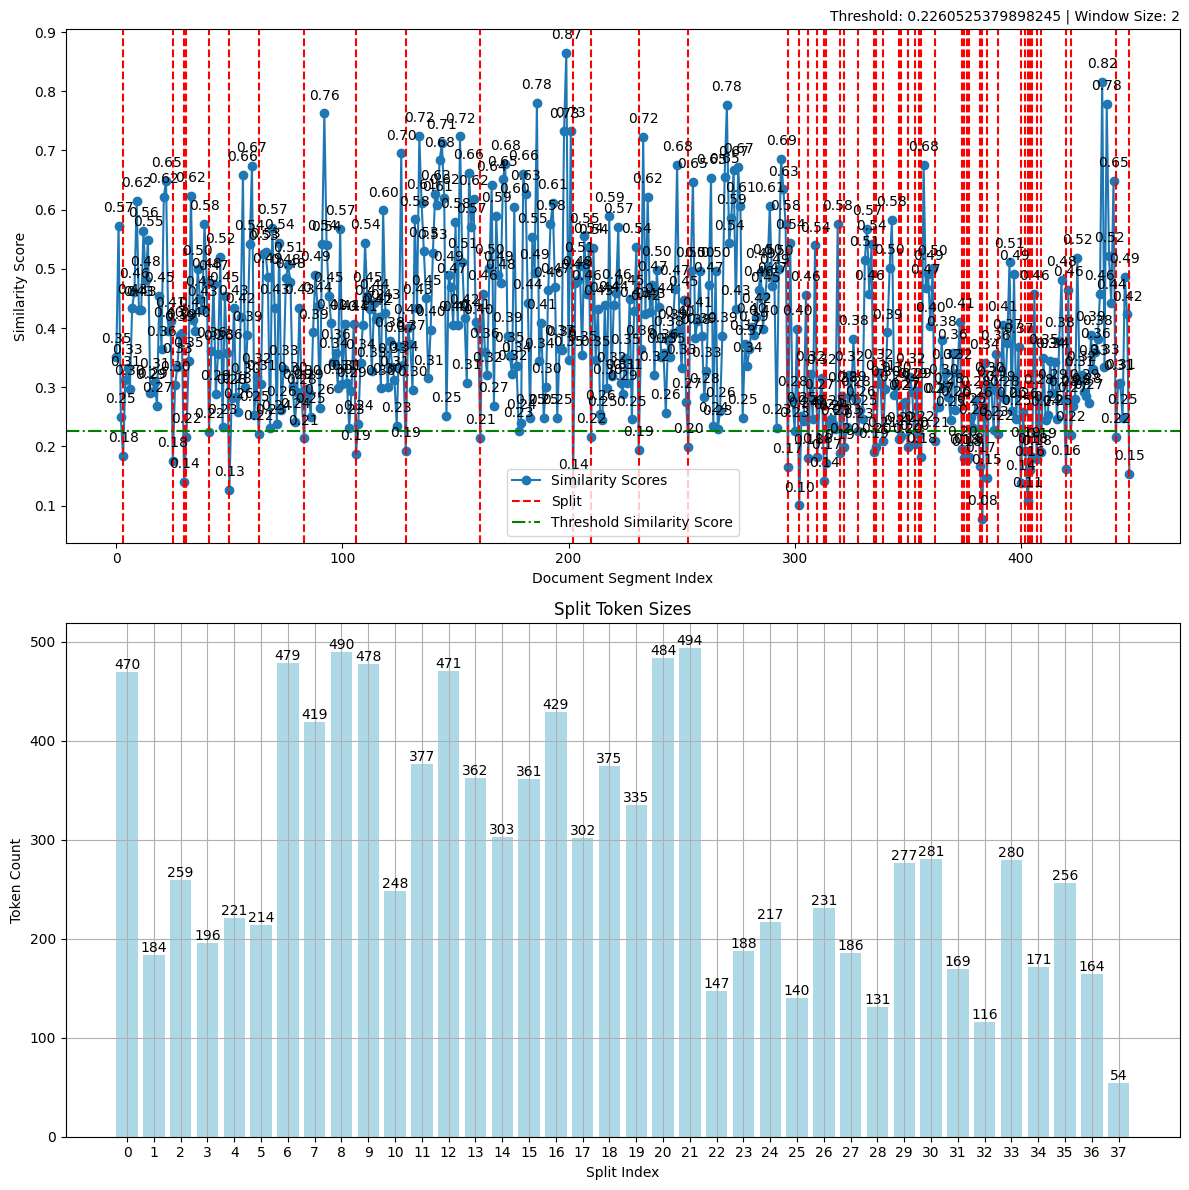

Splitting Statistics:
  - Total Documents: 450
  - Total Splits: 38
  - Splits by Threshold: 26
  - Splits by Max Chunk Size: 11
  - Last Split: 1
  - Minimum Token Size of Split: 54
  - Maximum Token Size of Split: 494
  - Similarity Split Ratio: 0.68


In [101]:
splits = splitter([dataset["content"][0]])

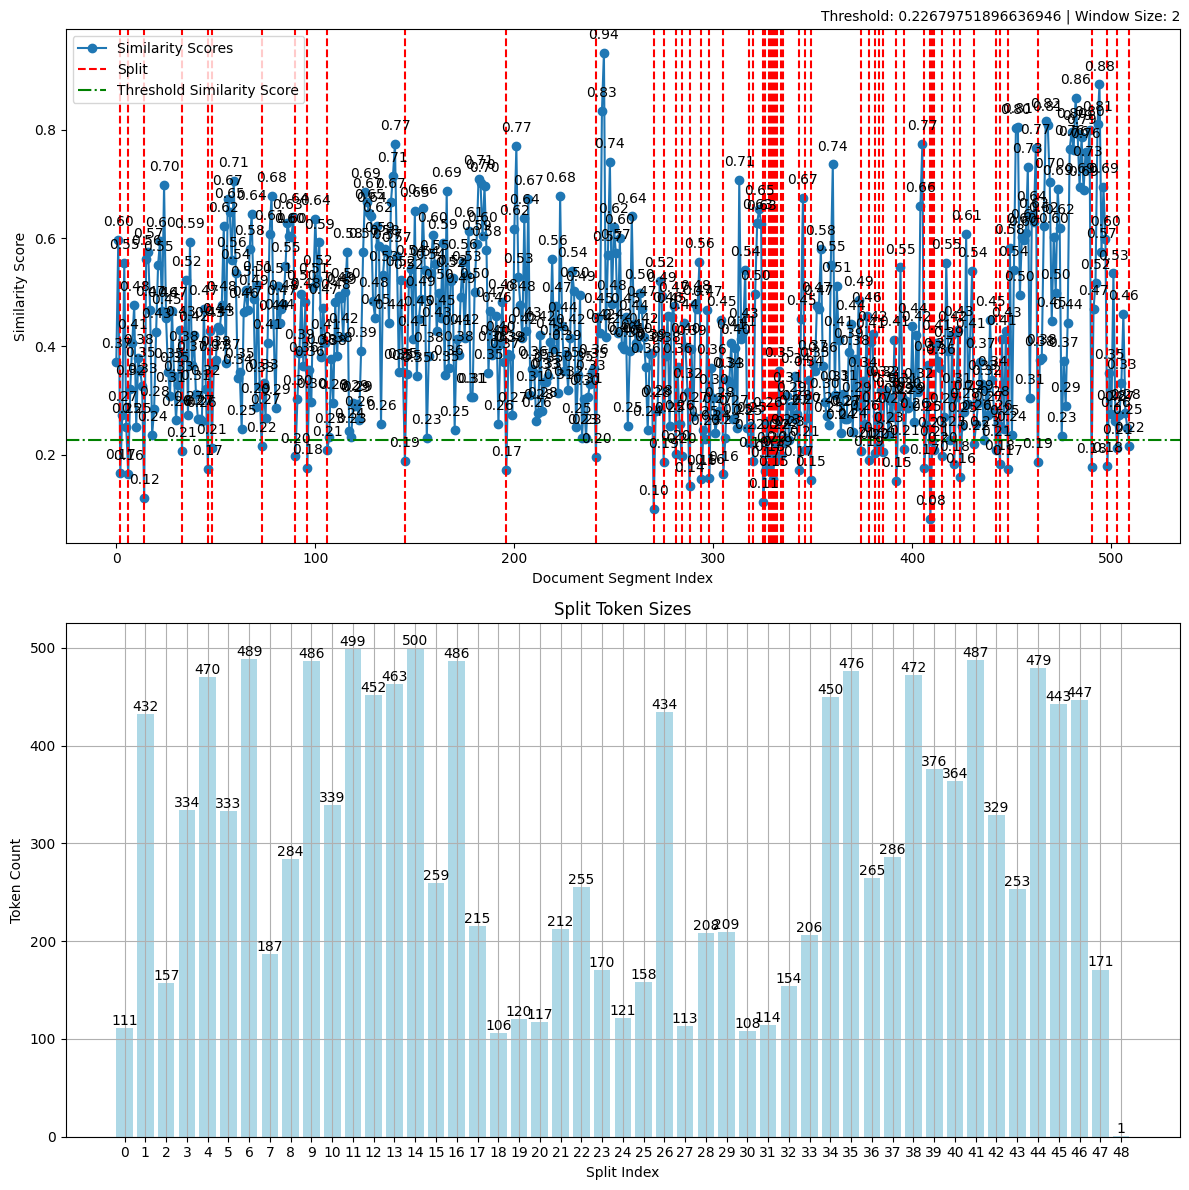

Splitting Statistics:
  - Total Documents: 511
  - Total Splits: 49
  - Splits by Threshold: 29
  - Splits by Max Chunk Size: 19
  - Last Split: 1
  - Minimum Token Size of Split: 1
  - Maximum Token Size of Split: 500
  - Similarity Split Ratio: 0.59


In [102]:
splits = splitter([dataset["content"][1]])

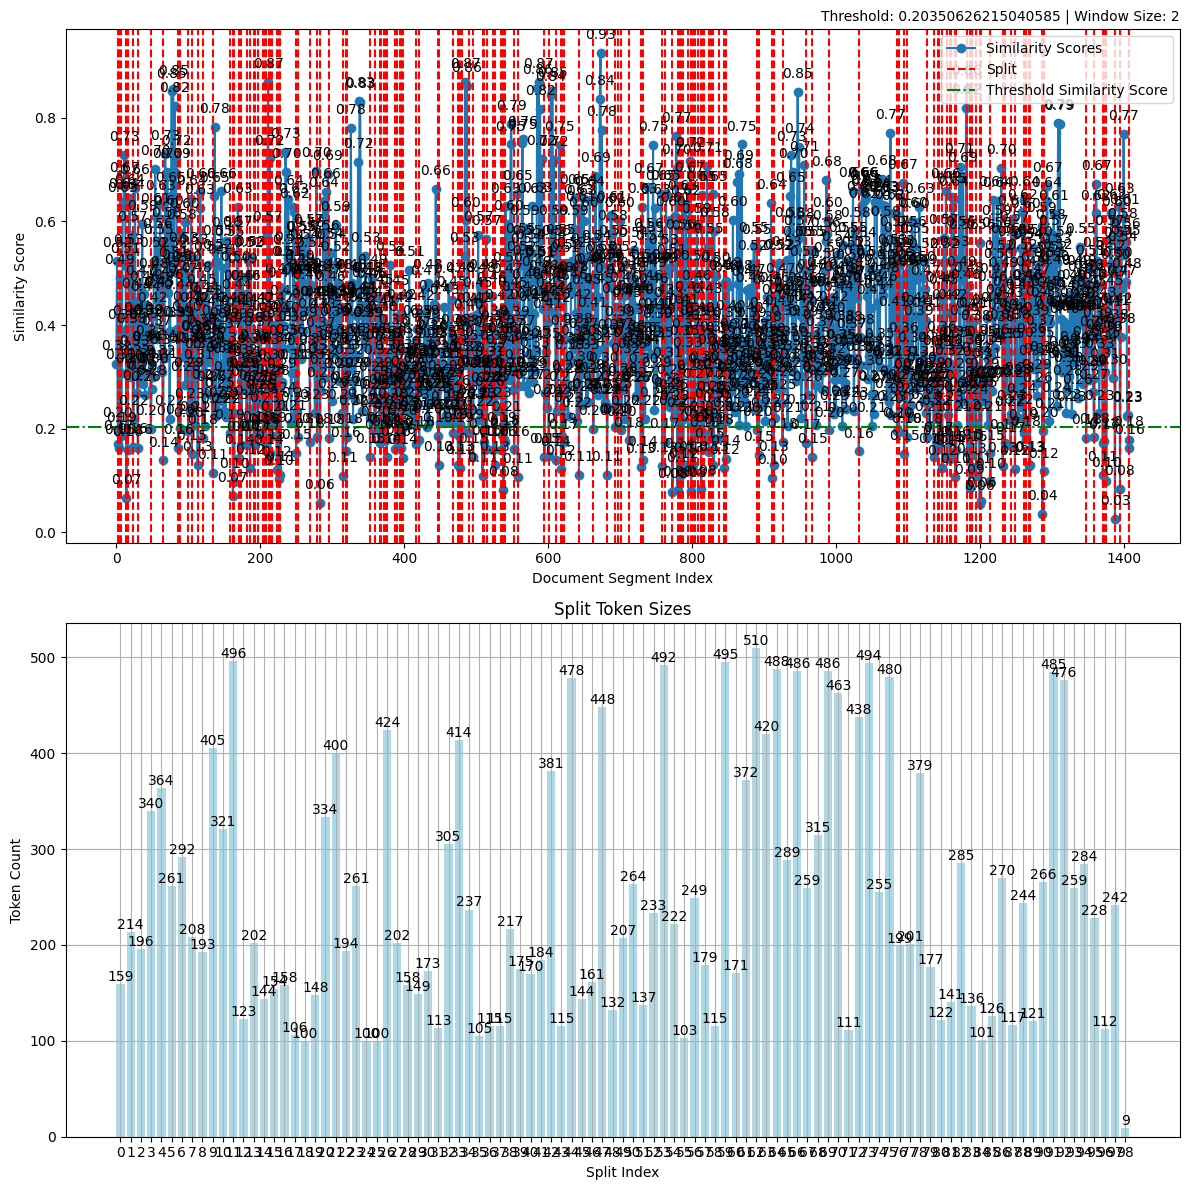

Splitting Statistics:
  - Total Documents: 1410
  - Total Splits: 99
  - Splits by Threshold: 83
  - Splits by Max Chunk Size: 15
  - Last Split: 1
  - Minimum Token Size of Split: 9
  - Maximum Token Size of Split: 510
  - Similarity Split Ratio: 0.84


In [103]:
splits = splitter([dataset["content"][2]])

We can view a few of our splits:

In [104]:
splitter.print(splits[:3])

Split 1, tokens 159, triggered by: 0.19
3 2 0 2 c e D 9 1 ] I A . s c [ 2 v 1 1 1 1 1 . 2 1 3 2 : v i X r a # The Good, The Bad, and Why: Unveiling Emotions in Generative AI* Cheng Li1,2, Jindong Wang1â , Yixuan Zhang3, Kaijie Zhu1, Xinyi Wang4, Wenxin Hou1, Jianxun Lian1, Fang Luo4, Qiang Yang5, Xing Xie1 1Microsoft Research 2Institute of Software, CAS 3William&Mary 4Beijing Normal University 5Hong Kong University of Science and Technology # Abstract
----------------------------------------------------------------------------------------


Split 2, tokens 214, triggered by: 0.07
Emotion significantly impacts our daily behaviors and interactions. While recent genera- tive AI models, such as large language models, have shown impressive performance in various tasks, it remains unclear whether they truly comprehend emotions. This paper aims to address this gap by incorporating psychological theories to gain a holistic understanding of emotions in generative AI models. Specifically, we pro

The actual structure of splits we get from this function is contained within a `DocumentSplit` object:

In [105]:
splits[:3]

[DocumentSplit(docs=['3 2 0 2 c e D 9 1', '] I A . s c [', '2 v 1 1 1 1 1 . 2 1 3 2 : v i X r a', '# The Good, The Bad, and Why:', 'Unveiling Emotions in Generative AI*', 'Cheng Li1,2, Jindong Wang1â', ', Yixuan Zhang3, Kaijie Zhu1, Xinyi Wang4, Wenxin Hou1, Jianxun Lian1, Fang Luo4, Qiang Yang5, Xing Xie1 1Microsoft Research 2Institute of Software, CAS 3William&Mary 4Beijing Normal University 5Hong Kong University of Science and Technology', '# Abstract'], is_triggered=True, triggered_score=0.18537181811439374, token_count=159, metadata=None),
 DocumentSplit(docs=['Emotion significantly impacts our daily behaviors and interactions.', 'While recent genera- tive AI models, such as large language models, have shown impressive performance in various tasks, it remains unclear whether they truly comprehend emotions.', 'This paper aims to address this gap by incorporating psychological theories to gain a holistic understanding of emotions in generative AI models.', 'Specifically, we propose 

In here, our chunks are separated into a list of _sentence-like_ strings. To output our chunk from this we use the `.content` attribute:

In [106]:
splits[0].content

'3 2 0 2 c e D 9 1 ] I A . s c [ 2 v 1 1 1 1 1 . 2 1 3 2 : v i X r a # The Good, The Bad, and Why: Unveiling Emotions in Generative AI* Cheng Li1,2, Jindong Wang1â , Yixuan Zhang3, Kaijie Zhu1, Xinyi Wang4, Wenxin Hou1, Jianxun Lian1, Fang Luo4, Qiang Yang5, Xing Xie1 1Microsoft Research 2Institute of Software, CAS 3William&Mary 4Beijing Normal University 5Hong Kong University of Science and Technology # Abstract'

When creating embeddings we can include additional contextual information to improve retrieval performance. One performant but simple method for this is to prefix titles or headers to our chunks — this works particularly well for more structured documents like PDFs.

We can define a function that will do this for us.

In [107]:
def build_chunk(title: str, content: str):
    return f"# {title}\n{content}"

# we use it like:
title = dataset[2]["title"]
for s in splits[:3]:
    print("---")
    print(build_chunk(title=title, content=s.content))

---
# The Good, The Bad, and Why: Unveiling Emotions in Generative AI
3 2 0 2 c e D 9 1 ] I A . s c [ 2 v 1 1 1 1 1 . 2 1 3 2 : v i X r a # The Good, The Bad, and Why: Unveiling Emotions in Generative AI* Cheng Li1,2, Jindong Wang1â , Yixuan Zhang3, Kaijie Zhu1, Xinyi Wang4, Wenxin Hou1, Jianxun Lian1, Fang Luo4, Qiang Yang5, Xing Xie1 1Microsoft Research 2Institute of Software, CAS 3William&Mary 4Beijing Normal University 5Hong Kong University of Science and Technology # Abstract
---
# The Good, The Bad, and Why: Unveiling Emotions in Generative AI
Emotion significantly impacts our daily behaviors and interactions. While recent genera- tive AI models, such as large language models, have shown impressive performance in various tasks, it remains unclear whether they truly comprehend emotions. This paper aims to address this gap by incorporating psychological theories to gain a holistic understanding of emotions in generative AI models. Specifically, we propose three approaches: 1) Emoti

These chunks are all we need to create our embeddings, but we don't necessarily want to feed the same information into our LLM that has been fed into our embedding model. In our example, we will add a little more structure to what the LLM sees, and also a little more context.

To achieve this, we will keep the `title` and `content` fields separate in metadata so that during retrieval we can format them in a way that makes sense for us.

Additionally, we may also want to pull in some context from surrounding chunks for the LLM — for that, we must track before and after chunks which we will place in two new metadata fields, `prechunk` and `postchunk`.

Last, but not least — we may want to allow for connections between different documents. To support this we will add a `arxiv_id` field that identifies _this_ paper, and also a `references` field that includes other paper's `arxiv_id` that were referenced in _this_ paper.

In [108]:
arxiv_id = dataset[2]["id"]
refs = list(dataset[2]["references"].values())

metadata = []
for i, s in enumerate(splits[:3]):
    prechunk = "" if i == 0 else splits[i-1].content
    postchunk = "" if i-1 == len(splits) else splits[i+1].content
    metadata.append({
        "title": title,
        "content": s.content,
        "prechunk": prechunk,
        "postchunk": postchunk,
        "arxiv_id": arxiv_id,
        "references": refs
    })

In [109]:
metadata[1]

{'title': 'The Good, The Bad, and Why: Unveiling Emotions in Generative AI',
 'content': 'Emotion significantly impacts our daily behaviors and interactions. While recent genera- tive AI models, such as large language models, have shown impressive performance in various tasks, it remains unclear whether they truly comprehend emotions. This paper aims to address this gap by incorporating psychological theories to gain a holistic understanding of emotions in generative AI models. Specifically, we propose three approaches: 1) EmotionPrompt 24 to enhance AI model performance, 2) EmotionAttack to impair AI model performance, and 3) EmotionDecode to explain the effects of emotional stimuli, both benign and malignant. Through extensive experiments involving language and multi-modal models on semantic un- derstanding, logical reasoning, and generation tasks, we demonstrate that both textual and visual EmotionPrompt can boost the performance of AI models while EmotionAttack can hin- der it. Add

In [110]:
from semantic_router.schema import DocumentSplit


def build_metadata(doc: dict, doc_splits: list[DocumentSplit]):
    # get document level metadata first
    arxiv_id = doc["id"]
    title = doc["title"]
    refs = list(doc["references"].values())
    # init split level metadata list
    metadata = []
    for i, split in enumerate(doc_splits):
        # get neighboring chunks
        prechunk_id = "" if i == 0 else f"{arxiv_id}#{i-1}"
        postchunk_id = "" if i+1 == len(doc_splits) else f"{arxiv_id}#{i+1}"
        # create dict and append to metadata list
        metadata.append({
            "id": f"{arxiv_id}#{i}",
            "title": title,
            "content": split.content,
            "prechunk_id": prechunk_id,
            "postchunk_id": postchunk_id,
            "arxiv_id": arxiv_id,
            "references": refs
        })
    return metadata

In [111]:
metadata = build_metadata(
    doc=dataset[2],
    doc_splits=splits[:3]
)

In [112]:
metadata

[{'id': '2312.11111#0',
  'title': 'The Good, The Bad, and Why: Unveiling Emotions in Generative AI',
  'content': '3 2 0 2 c e D 9 1 ] I A . s c [ 2 v 1 1 1 1 1 . 2 1 3 2 : v i X r a # The Good, The Bad, and Why: Unveiling Emotions in Generative AI* Cheng Li1,2, Jindong Wang1â , Yixuan Zhang3, Kaijie Zhu1, Xinyi Wang4, Wenxin Hou1, Jianxun Lian1, Fang Luo4, Qiang Yang5, Xing Xie1 1Microsoft Research 2Institute of Software, CAS 3William&Mary 4Beijing Normal University 5Hong Kong University of Science and Technology # Abstract',
  'prechunk_id': '',
  'postchunk_id': '2312.11111#1',
  'arxiv_id': '2312.11111',
  'references': ['2210.09261']},
 {'id': '2312.11111#1',
  'title': 'The Good, The Bad, and Why: Unveiling Emotions in Generative AI',
  'content': 'Emotion significantly impacts our daily behaviors and interactions. While recent genera- tive AI models, such as large language models, have shown impressive performance in various tasks, it remains unclear whether they truly comprehe

When feeding this structure into our LLM we will be able to tweak the exact format, how much info we provide, and how we handle connected documents — but by having this info here we can quickly iterate on the later generative steps.

## Implementation and Indexing

So far, we've seen how to process our data but we still haven't process our full dataset, nor have we begun embedding and storing our data. Now, we will do that.

To begin, we will setup a Pinecone index where we'll be storing everything.

In [113]:
from pinecone import Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.getenv("PINECONE_API_KEY") or getpass("Pinecone API key: ")

# configure client
pc = Pinecone(api_key=api_key, source_tag="pinecone_examples:learn:better_rag:02b_semantic_chunking")

Now we setup our index specification, this allows us to define the cloud provider and region where we want to deploy our index. You can find a list of all [available providers and regions here](https://docs.pinecone.io/guides/projects/understanding-projects).

In [114]:
from pinecone import ServerlessSpec

spec = ServerlessSpec(
    cloud="aws", region="us-east-1"  # us-east-1
)

Before creating an index, we need the dimensionality of our OpenAI embedding model, we get this by embedding an example and measuring the vector dimension:

In [115]:
dims = len(encoder(["some random text"])[0])
dims

1536

Now we create the index using our embedding dimensionality, and a metric also compatible with the model (this can be either cosine or dotproduct). We also pass our spec to index initialization.

In [116]:
import time

index_name = "better-rag-chunking"

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=dims,  # dimensionality of embed 3
        metric='dotproduct',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'dotproduct',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

# Populating our Index

Now our knowledge base is ready to be populated with our data. We will use the embed helper function to embed our documents and then add them to our index.

We will also include metadata from each record in the format we developed earlier.

---

_**Note**: You can find a prechunked version of the dataset [here](https://huggingface.co/datasets/jamescalam/ai-arxiv2-semantic-chunks) — you can use this to save time and money on chunking by loading from HF datasets with:_

```python
dataset = load_dataset(
    "jamescalam/ai-arxiv2-semantic-chunks",
    split="train[:10000]"
)
```

_You can also reduce the dataset size via the `split` parameter, to use only the first 10K rows we write `split="train[:10000]"`._

---

In [117]:
from tqdm.auto import tqdm

# easier to work with dataset as pandas dataframe
data = dataset.to_pandas().iloc[:200]
# store dataset *without* embeddings here
full_dataset = []

batch_size = 128

# adjust splitter to not display stats and visuals
splitter.enable_statistics = False
splitter.plot_splits = False

for doc in tqdm(dataset):
    # create splits
    splits = splitter([doc["content"]])
    # create IDs and metadata for all splits in doc
    metadata = build_metadata(doc=doc, doc_splits=splits)
    for i in range(0, len(splits), batch_size):
        i_end = min(len(splits), i+batch_size)
        # get batch of data
        metadata_batch = metadata[i:i_end]
        full_dataset.extend(metadata_batch)
        # generate unique ids for each chunk
        ids = [m["id"] for m in metadata_batch]
        # get text content to embed
        content = [
            build_chunk(
                title=x["title"], content=x["content"]
            ) for x in metadata_batch
        ]
        # embed text
        embeds = encoder(content)
        # add to Pinecone
        index.upsert(vectors=zip(ids, embeds, metadata))

100%|██████████| 100/100 [06:53<00:00,  4.13s/it]


Now that we have our chunks stored we can go ahead and begin querying against them...

In [118]:
def query(text: str):
    xq = encoder([text])[0]
    matches = index.query(
        vector=xq,
        top_k=3,
        include_metadata=True
    )
    chunks = []
    for m in matches["matches"]:
        content = m["metadata"]["content"]
        title = m["metadata"]["title"]
        pre = m["metadata"]["prechunk_id"]
        post = m["metadata"]["postchunk_id"]
        other_chunks = index.fetch(ids=[pre, post]).vectors
        prechunk = other_chunks[pre]["metadata"]["content"]
        postchunk = other_chunks[post]["metadata"]["content"]
        chunk = f"""# {title}

        {prechunk[-400:]}
        {content}
        {postchunk[:400]}"""
        chunks.append(chunk)
    return chunks

In [119]:
query("what are large language models?")

['# Large Language Models as Optimizers\n\n        lt, and Giovanni Rinaldi. The traveling salesman problem. Handbooks in operations research and management science, 7:225â 330, 1995. Geunwoo Kim, Pierre Baldi, and Stephen McAleer. Language models can solve computer tasks. arXiv preprint arXiv:2303.17491, 2023. Diederik P Kingma and Jimmy Ba. Adam: A method for stochastic optimization. In International Conference on Learning Representations, 2015.\n        Takeshi Kojima, Shixiang Shane Gu, Machel Reid, Yutaka Matsuo, and Yusuke Iwasawa. Large language models are zero-shot reasoners. arXiv preprint arXiv:2205.11916, 2022. Wouter Kool, Herke van Hoof, and Max Welling. Attention, learn to solve routing problems! In International Conference on Learning Representations, 2019. URL https://openreview. net/forum?id=ByxBFsRqYm. Joel Lehman, Jonathan Gordon, Shawn Jain, Kamal Ndousse, Cathy Yeh, and Kenneth O Stanley. Evolution through large models. arXiv preprint arXiv:2206.08896, 2022. Brian 

Once finished, you can delete your Pinecone index to save resources — _**but careful, this cannot be recovered without rerunning the index process!**_

In [120]:
answer = input("Type 'y' to confirm deletion of the index...\n>> ")
if answer == "y":
    pc.delete_index(index_name)
    print("Index Deleted!")
else:
    print("Deletion Cancelled")

Index Deleted!


---